In [1]:
import numpy as np
from matplotlib import pyplot as plt
from openbci_stream.utils.hdf5 import HDF5Reader

# Appendix 5 - Markers synchronization

Is possible to take advantage of the OpenBCI construction, this board includes a set of analog and digital inputs that can be used to synchronize markers. Other systems will need a piece of additional laboratory equipment like [LabStreamer](https://www.neurobs.com/menu_presentation/menu_hardware/labstreamer) that can register time with microseconds precision. In order to use OpenBCI, we will only need an _LDR module_ connected to the pin **D11** (or **A5**) and start the automatic latency correction system. This method is similar to the one implemented by <cite data-footcite="davis2020stimulus">davis2020stimulus</cite>.

In [2]:
reader = HDF5Reader('data/record-markers_offset.h5')
aux = reader.aux
aux_timestamp = reader.aux_timestamp
markers = reader.markers
print(reader)

data/record-markers_offset.h5
2021-10-28 22:10:49.579271
MARKERS: ['Right', '1', 'Retention', 'No-changed', 'No-response', 'Left', 'Identical', '2', 'Changed', 'Different', '4']
SAMPLE_RATE: 1000
STREAMING_SAMPLE_RATE: 100
DATETIME: 1635477049.579271
MONTAGE: standard_1020
CHANNELS: {1: 'Fp1', 2: 'Fp2', 3: 'F7', 4: 'F3', 5: 'Fz', 6: 'F4', 7: 'F8', 8: 'T7', 9: 'T8', 10: 'P7', 11: 'P3', 12: 'Pz', 13: 'P4', 14: 'P8', 15: 'O1', 16: 'O2'}
CHANNELS_BY_BOARD: [16]
SHAPE: [16, 1527998]


## Rise-up detectors

The method `get_rises` will return the timestamps locations of the `rise-ups` in the signal.

In [19]:
lower_val = 260
upper_val = 750
rises = reader.get_rises(aux[0], aux_timestamp[0], lower=lower_val, upper=upper_val)

Text(0, 0.5, 'Amplitude')

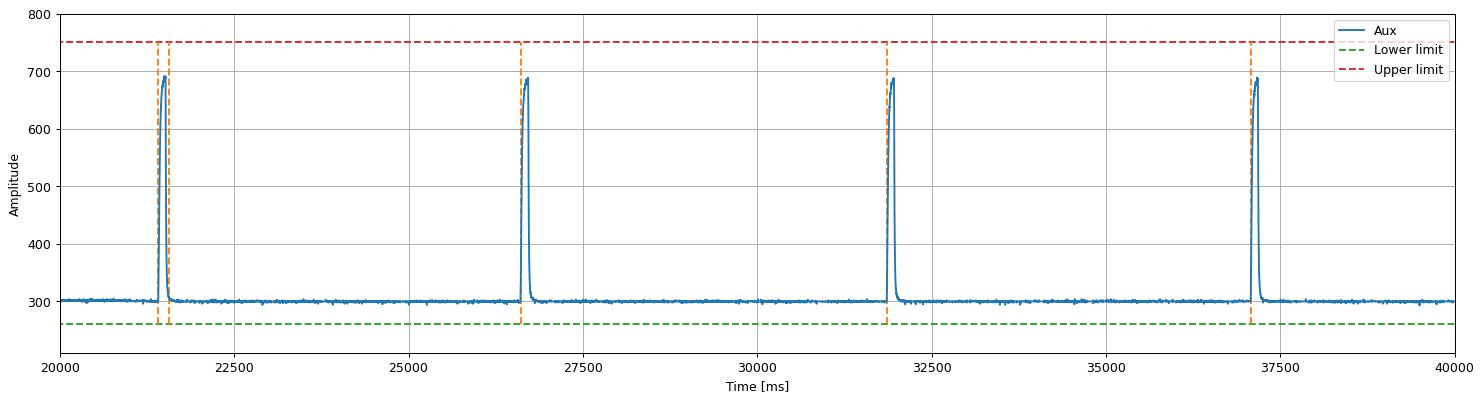

In [27]:
plt.figure(figsize=(20, 5), dpi=90)
plt.grid(True)
plt.plot(aux_timestamp[0], aux[0], color='C0', label='Aux')
plt.hlines(lower_val, 0, aux_timestamp[0][-1], color='C2', linestyle='--', label='Lower limit')
plt.hlines(upper_val, 0, aux_timestamp[0][-1], color='C3', linestyle='--', label='Upper limit')
plt.vlines(rises, lower_val, upper_val, color='C1', linestyle='--')
plt.ylim(lower_val-50, upper_val+50)
plt.xlim(20000, 40000)
plt.legend()

plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')

This `rise-ups` will show the markers offsets:

Text(0, 0.5, 'Amplitude')

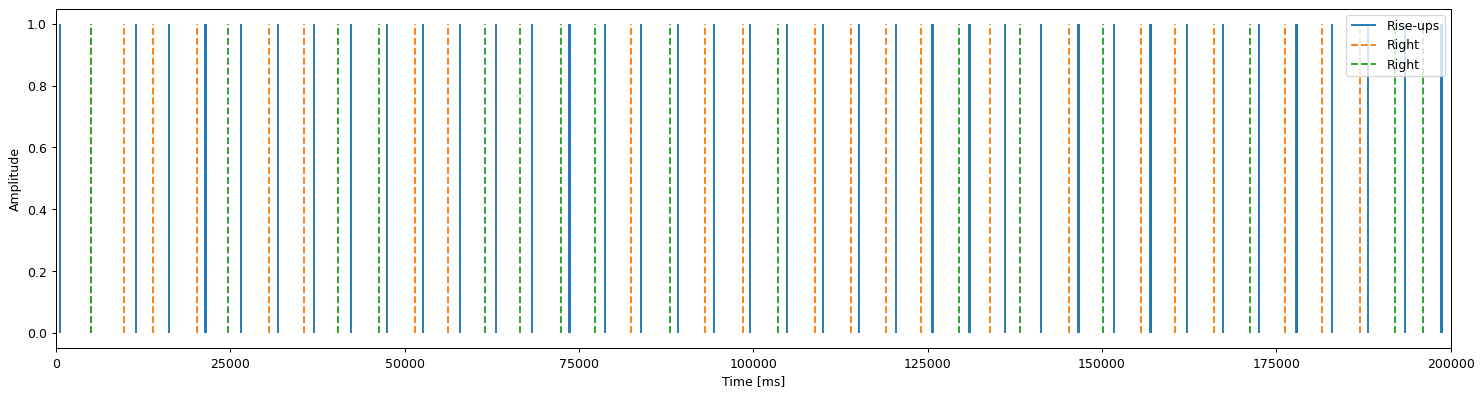

In [28]:
plt.figure(figsize=(20, 5), dpi=90)

plt.vlines(rises, 0, 1, color='C0', label='Rise-ups')
plt.vlines(markers['Right'], 0, 1, color='C1', linestyle='--', label='Right')
plt.vlines(markers['Left'], 0, 1, color='C2', linestyle='--', label='Right')

plt.legend()
plt.xlim(0, 2e5)

plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')

## Markers synchronization

With the `rises` is possible to relocate the markers by calculating the offsets with the method `fix_markers`:

In [29]:
offsets = reader.fix_markers(['Right', 'Left'], rises, 2000)
offsets

{'Right': 1155.8761177062988, 'Left': 1106.335189819336}

The `offsets` can be used to subtract them from the original markers.

Text(0, 0.5, 'Amplitude')

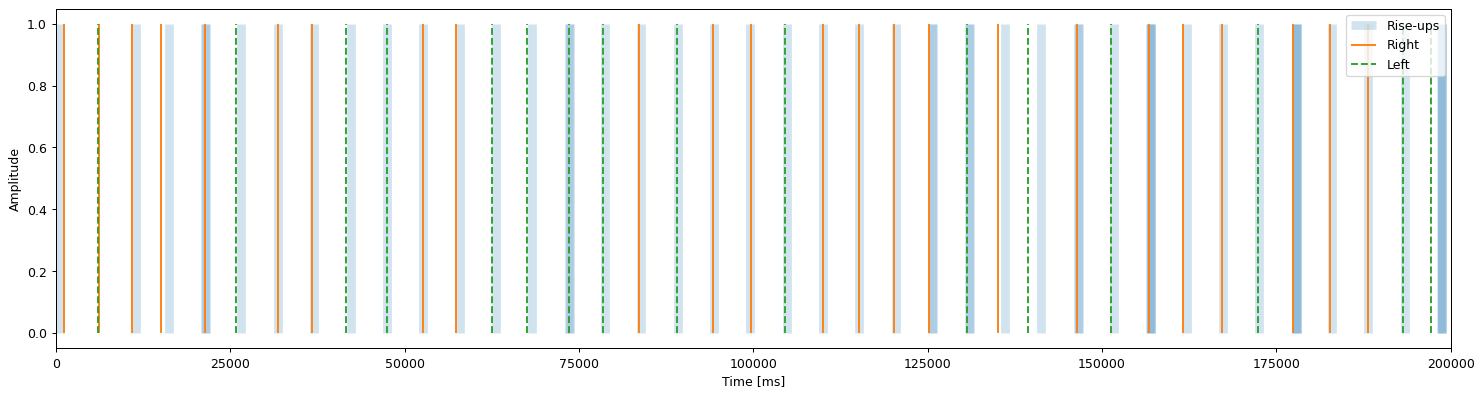

In [30]:
plt.figure(figsize=(20, 5), dpi=90)

plt.vlines(rises, 0, 1, color='C0', linewidth=7, alpha=0.2, label='Rise-ups')
plt.vlines(markers['Right'] + offsets['Right'], 0, 1, color='C1', linestyle='-', label='Right')
plt.vlines(markers['Left'] + offsets['Left'], 0, 1, color='C2', linestyle='--', label='Left')

plt.legend()
plt.xlim(0, 2e5)

plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')

The method `fix_markers` will also create a new set markers but synchronized one by one, the new markers will have the `_fixed` sufix:

Text(0, 0.5, 'Amplitude')

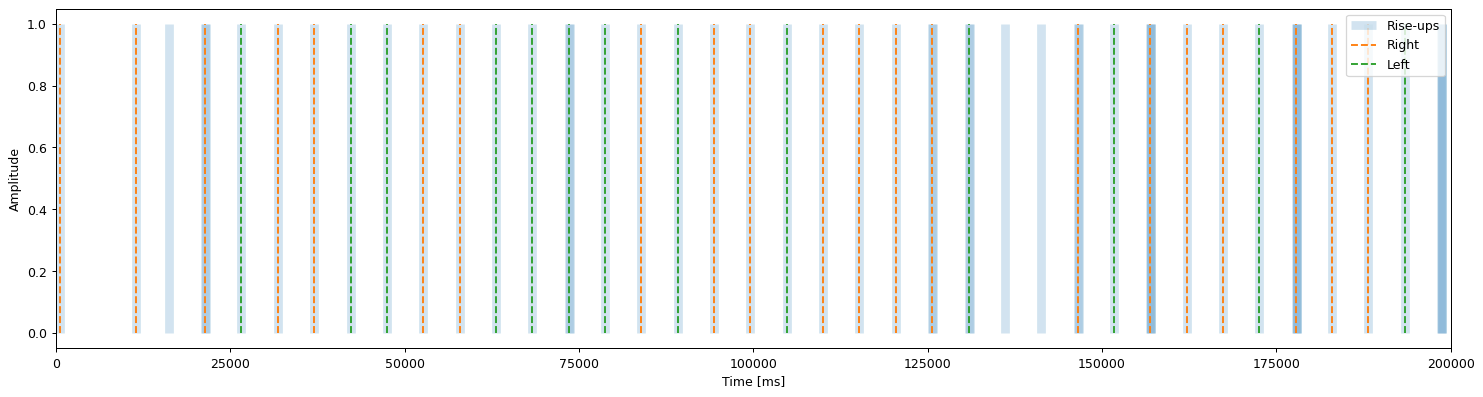

In [31]:
plt.figure(figsize=(20, 5), dpi=90)

plt.vlines(rises, 0, 1, color='C0', linewidth=7, alpha=0.2, label='Rise-ups')
plt.vlines(markers['Right_fixed'], 0, 1, color='C1', linestyle='--', label='Right')
plt.vlines(markers['Left_fixed'], 0, 1, color='C2', linestyle='--', label='Left')

plt.legend()
plt.xlim(0, 2e5)

plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')

This simple latency correction consists of synchronize the _hardware markers_ with the _software markers_, the _LDR module_ is constantly sensing (the [boardmode](02-interface.ipynb#Connection) must be in `analog`) so the changes on the square signal (the rise-up) are compared with streamed markers and then the latency is corrected. The latency correction **only affects the current HDF5Reader session**, it does not store this correction on the file. 

---
.. footbibliography::